In [1]:
from copy import deepcopy
import gymnasium as gym
import gym_pusht
from gymnasium.wrappers import RecordVideo
from IPython.display import Video, Image
import matplotlib.pyplot as plt
import numba
import numpy as np
import torch
import tqdm

from rl_playground.episodes import *
from rl_playground.utils import *

%load_ext autoreload
%autoreload 2

In [2]:
# env = gym.make("MountainCar-v0", render_mode="rgb_array")
# record_video(env, name="MountainCarRandom", horizon=10)
# Video("gym_videos/MountainCarRandom/rl-video-episode-0.mp4", embed=True)

In [3]:
env = gym.make(
    "gym_pusht/PushT-v0", obs_type="pixels_agent_pos", render_mode="rgb_array"
)
env = ScaleRewardWrapper(env)
# record_video(env, horizon=180, name="PushTRandom")

In [4]:
# Video("gym_videos/PushTRandom/rl-video-episode-0.mp4", embed=True)

Obs agent pos: (2,)
Obs image: (96, 96, 3)
Action: (2,)


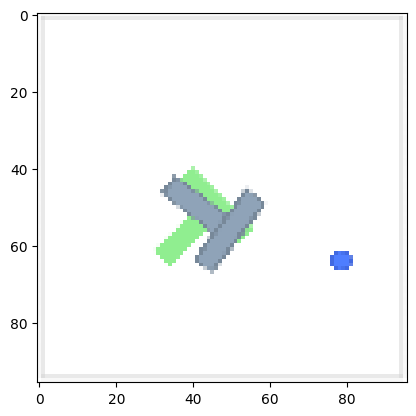

In [5]:
s, _ = env.reset()
print("Obs agent pos:", s["agent_pos"].shape)
print("Obs image:", s["pixels"].shape)
# Inspect element
plt.imshow(s["pixels"])
a = env.action_space.sample()
print("Action:", a.shape)

In [6]:
rollout = get_rollout(episode_length=100, policy=None, env=env)

print(rollout.keys())
print("States shape:", len(rollout["states"]))
print("Actions shape:", len(rollout["actions"]))
print("Reached goals", len(rollout["reached_goals"]))
print("Reached goals:", type(rollout["reached_goals"]))
print("Desired goal:", type(rollout["desired_goal"]))
print("Goal image shape:", rollout["desired_goal"]["pixels"].shape)
print("Goal agent pos shape:", rollout["desired_goal"]["agent_pos"].shape)

dict_keys(['states', 'actions', 'reached_goals', 'desired_goal'])
States shape: 100
Actions shape: 100
Reached goals 100
Reached goals: <class 'list'>
Desired goal: <class 'dict'>
Goal image shape: (96, 96, 3)
Goal agent pos shape: (2,)


In [7]:
roll_split = split_trajectory(rollout)
print(roll_split.keys())
# Elements dimensions
print("States agent pos shape:", roll_split["states_agent_pos"].shape)
print("States pixels shape:", roll_split["states_pixels"].shape)
print("Actions shape:", roll_split["actions"].shape)
print("Reached goals agent pos shape:", roll_split["reached_goals_agent_pos"].shape)
print("Reached goals pixels shape:", roll_split["reached_goals_pixels"].shape)
print("Desired goal agent pos shape:", roll_split["desired_goal_agent_pos"].shape)
print("Desired goal pixels shape:", roll_split["desired_goal_pixels"].shape)

dict_keys(['states_agent_pos', 'states_pixels', 'actions', 'reached_goals_agent_pos', 'reached_goals_pixels', 'desired_goal_agent_pos', 'desired_goal_pixels'])
States agent pos shape: (100, 2)
States pixels shape: (100, 96, 96, 3)
Actions shape: (100, 2)
Reached goals agent pos shape: (100, 2)
Reached goals pixels shape: (100, 96, 96, 3)
Desired goal agent pos shape: (1, 2)
Desired goal pixels shape: (1, 96, 96, 3)


In [16]:
trajectories = [
    get_rollout(episode_length=i, policy=None, env=env) for i in range(25, 27)
]

dataset = PushTDatasetFromTrajectories(
    trajectories, pred_horizon=16, obs_horizon=2, action_horizon=8
)
print(dataset.indices)
print(dataset.train_data["agent_pos"].shape)
print(dataset.train_data["action"].shape)
print(dataset.train_data["image"].shape)
print(dataset.train_data["reached_goal_agent_pos"].shape)
print(dataset.train_data["reached_goal_image"].shape)
# print(dataset.train_data["desired_goal_agent_pos"].shape)
# print(dataset.train_data["desired_goal_image"].shape)

[[ 0 16  0 16]
 [ 1 17  0 16]
 [ 2 18  0 16]
 [ 3 19  0 16]
 [ 4 20  0 16]
 [ 5 21  0 16]
 [ 6 22  0 16]
 [ 7 23  0 16]
 [ 8 24  0 16]
 [ 9 25  0 16]
 [25 41  0 16]
 [26 42  0 16]
 [27 43  0 16]
 [28 44  0 16]
 [29 45  0 16]
 [30 46  0 16]
 [31 47  0 16]
 [32 48  0 16]
 [33 49  0 16]
 [34 50  0 16]
 [35 51  0 16]]
(51, 2)
(51, 2)
(51, 3, 96, 96)
(51, 2)
(51, 3, 96, 96)


In [11]:
trajectories = [
    get_rollout(episode_length=i, policy=None, env=env) for i in range(25, 27)
]

dataset = PushTDatasetFromTrajectories(
    trajectories, pred_horizon=16, obs_horizon=2, action_horizon=8
)
first_item = dataset[0]
# print(f"First item: {first_item}")
print(f"First item keys: {first_item.keys()}")
print(f"First item['image'].shape: {first_item['image'].shape}")
print(f"First item['agent_pos'].shape: {first_item['agent_pos'].shape}")
print(f"First item['action'].shape: {first_item['action'].shape}")
print(
    f"First item['desired_goal_agent_pos'].shape: {first_item['desired_goal_agent_pos'].shape}"
)
print(
    f"First item['desired_goal_image'].shape: {first_item['desired_goal_image'].shape}"
)
print(
    f"First item['reached_goal_agent_pos'].shape: {first_item['reached_goal_agent_pos'].shape}"
)
print(
    f"First item['reached_goal_image'].shape: {first_item['reached_goal_image'].shape}"
)
print(len(dataset))

First item keys: dict_keys(['agent_pos', 'action', 'image', 'reached_goal_agent_pos', 'reached_goal_image'])
First item['image'].shape: (2, 3, 96, 96)
First item['agent_pos'].shape: (2, 2)
First item['action'].shape: (16, 2)


KeyError: 'desired_goal_agent_pos'

In [17]:
trajectories = [
    get_rollout(episode_length=i, policy=None, env=env) for i in range(25, 30)
]

dataset = PushTDatasetFromTrajectories(
    trajectories,
    pred_horizon=16,
    obs_horizon=2,
    action_horizon=8,
    get_original_goal=True,
)
first_item = dataset[0]
# print(f"First item: {first_item}")
print(f"First item keys: {first_item.keys()}")
print(f"First item['image'].shape: {first_item['image'].shape}")
print(f"First item['agent_pos'].shape: {first_item['agent_pos'].shape}")
print(f"First item['action'].shape: {first_item['action'].shape}")
print(
    f"First item['desired_goal_agent_pos'].shape: {first_item['desired_goal_agent_pos'].shape}"
)
print(
    f"First item['desired_goal_image'].shape: {first_item['desired_goal_image'].shape}"
)
print(
    f"First item['reached_goal_agent_pos'].shape: {first_item['reached_goal_agent_pos'].shape}"
)
print(
    f"First item['reached_goal_image'].shape: {first_item['reached_goal_image'].shape}"
)
print(len(dataset))

First item keys: dict_keys(['agent_pos', 'action', 'image', 'reached_goal_agent_pos', 'reached_goal_image', 'desired_goal_agent_pos', 'desired_goal_image'])
First item['image'].shape: (2, 3, 96, 96)
First item['agent_pos'].shape: (2, 2)
First item['action'].shape: (16, 2)
First item['desired_goal_agent_pos'].shape: (2,)
First item['desired_goal_image'].shape: (3, 96, 96)
First item['reached_goal_agent_pos'].shape: (2,)
First item['reached_goal_image'].shape: (3, 96, 96)
60


In [52]:
# Test if first item actions are the same as the ones in the trajectory
print(np.allclose(first_item["action"], trajectories[0]["actions"][:16]))

# Test if first item image is the same as the one in the trajectory
print(
    np.allclose(
        first_item["image"][0].transpose(1, 2, 0),
        trajectories[0]["states"][0]["pixels"] / 255.0,
    )
)

# Test if first item agent pos is the same as the one in the trajectory
print(
    np.allclose(first_item["agent_pos"][0], trajectories[0]["states"][0]["agent_pos"])
)

# Test if first item reached goal agent pos is the same as the one in the trajectory
print(
    np.allclose(
        first_item["reached_goal_agent_pos"],
        trajectories[0]["reached_goals"][16]["agent_pos"],
        trajectories[0]["states"][17]["agent_pos"],
    )
)

# All true with zero padding

True
True
True
True


In [76]:
# create dataloader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=64,
    num_workers=0,
    shuffle=True,
    # accelerate cpu-gpu transfer
    pin_memory=True,
    # don't kill worker process afte each epoch
    persistent_workers=False,
)

# visualize data in batch
batch = next(iter(dataloader))
print(
    "batch['image'].shape:", batch["image"].shape
)  # (batch_size, obs_horizon, C, H, W)
print(
    "batch['agent_pos'].shape:", batch["agent_pos"].shape
)  # (batch_size, obs_horizon, 2)
print("batch['action'].shape", batch["action"].shape)  # (batch_size, action_horizon, 2)
print(
    "batch['desired_goal_agent_pos'].shape:", batch["desired_goal_agent_pos"].shape
)  # (batch_size, 2)
print(
    "batch['desired_goal_image'].shape:", batch["desired_goal_image"].shape
)  # (batch_size, C, H, W)
print(
    "batch['reached_goal_agent_pos'].shape:", batch["reached_goal_agent_pos"].shape
)  # (batch_size, 2)
print(
    "batch['reached_goal_image'].shape:", batch["reached_goal_image"].shape
)  # (batch_size, C, H, W)

batch['image'].shape: torch.Size([64, 2, 3, 96, 96])
batch['agent_pos'].shape: torch.Size([64, 2, 2])
batch['action'].shape torch.Size([64, 16, 2])
batch['desired_goal_agent_pos'].shape: torch.Size([64, 2])
batch['desired_goal_image'].shape: torch.Size([64, 3, 96, 96])
batch['reached_goal_agent_pos'].shape: torch.Size([64, 2])
batch['reached_goal_image'].shape: torch.Size([64, 3, 96, 96])


In [59]:
n_obs_steps = 2
horizon = 6
n_action_steps = 1

print([i for i in range(1 - n_obs_steps, 1)])
print([i for i in range(1 - n_obs_steps, 1 - n_obs_steps + horizon)])

[-1, 0]
[-1, 0, 1, 2, 3, 4]


## Get statistics

In [60]:
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset

dataset = LeRobotDataset("lerobot/pusht")

/home/halvardbariller/miniconda3/envs/rl_perso/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 222 files: 100%|██████████| 222/222 [00:00<00:00, 7870.77it/s]


In [63]:
dataset.stats.keys()

dict_keys(['action', 'episode_index', 'frame_index', 'index', 'next.done', 'next.reward', 'next.success', 'observation.image', 'observation.state', 'timestamp'])

In [67]:
# test = dataset.stats["action", "observation.state"]
test = {k: dataset.stats[k] for k in ["action", "observation.state"]}

In [68]:
test

{'action': {'max': tensor([511., 511.]),
  'mean': tensor([228.2396, 293.9891]),
  'min': tensor([12., 25.]),
  'std': tensor([101.5996,  96.0393])},
 'observation.state': {'max': tensor([496.1462, 510.9579]),
  'mean': tensor([229.1110, 293.3110]),
  'min': tensor([13.4564, 32.9383]),
  'std': tensor([101.8547,  96.4895])}}

In [76]:
demonstrations = LeRobotDataset("lerobot/pusht")
demonstrations_statistics = {
    k: demonstrations.stats[k] for k in ["action", "observation.state"]
}

# parameters
pred_horizon = 16
obs_horizon = 2
action_horizon = 8

dataset = PushTDatasetFromTrajectories(
    trajectories,
    pred_horizon=pred_horizon,
    obs_horizon=obs_horizon,
    action_horizon=action_horizon,
    get_original_goal=False,
    dataset_statistics=demonstrations_statistics,
)

Fetching 222 files: 100%|██████████| 222/222 [00:00<00:00, 10341.24it/s]


In [77]:
dataset[0]

{'agent_pos': array([[-0.46738635,  0.01276898],
        [-0.46738635,  0.01276898]]),
 'action': array([[ 0.96663773,  0.7850697 ],
        [ 0.96663773,  0.7850697 ],
        [-0.00548816, -0.8222374 ],
        [-0.8310049 , -0.86403257],
        [ 0.09667075, -0.9940915 ],
        [ 0.69580305, -0.5027053 ],
        [-0.35563672, -0.06748867],
        [ 0.6089151 ,  0.8936937 ],
        [ 0.90504134,  0.7356423 ],
        [ 0.38220775, -0.22864574],
        [ 0.66850805, -0.39149034],
        [ 0.3343656 , -0.8905223 ],
        [-0.32924128,  0.19324386],
        [ 0.28676867, -1.0896404 ],
        [ 0.24290764,  0.892455  ],
        [ 0.8979981 , -0.5056248 ]], dtype=float32),
 'image': array([[[[1.        , 0.972549  , 0.972549  , ..., 0.972549  ,
           0.972549  , 1.        ],
          [0.972549  , 0.87058824, 0.9137255 , ..., 0.9137255 ,
           0.87058824, 0.972549  ],
          [0.96862745, 0.9137255 , 1.        , ..., 1.        ,
           0.9137255 , 0.96862745],
 

## Get goal with completed task

Obs agent pos: (2,)
Obs image: (96, 96, 3)


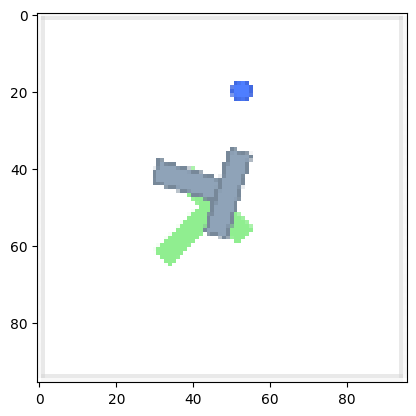

In [80]:
s, _ = env.reset()
print("Obs agent pos:", s["agent_pos"].shape)
print("Obs image:", s["pixels"].shape)
# Inspect element
plt.imshow(s["pixels"])

[272.9993  249.34567]


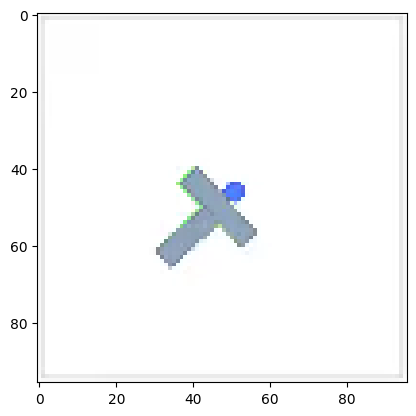

In [106]:
spixels = demonstrations[578]["observation.image"].numpy().transpose(1, 2, 0)
sagent_pos = demonstrations[578]["observation.state"].numpy()
plt.imshow(spixels)
print(sagent_pos)

In [107]:
termination_goal = {"agent_pos": sagent_pos, "pixels": spixels}

np.savez("termination_goal.npz", **termination_goal)